## Distmat

In [2]:
from ipynb.fs.full.koselleck import *

[Koselleck] (13:14:41) Alles bereit 


In [4]:
def distmat(word,
            ymin=YMIN_DISTMAT,#_BIG,
            ymax=YMAX_DISTMAT,#_BIG,
            ybin=YBIN_DISTMAT,#_BIG,
            k=K,
            force=False,
            cache=True,
            dist_key='dist',
            **ldist_opts):
    qstr=f'{word}/{ymin}-{ymax}_{ybin}/k={k}'
    if not force and cache:
        with get_db('distmat','r') as db:
            if qstr in db:
                odf=db[qstr]
                return odf
    try:
        dfldist=ldist(word, ymin=ymin,ymax=ymax,ybin=ybin,k=k, **ldist_opts)
        idf=dfldist.reset_index()
        idf=idf.append(idf.assign(period1=idf.period2, period2=idf.period1))
        dfdistmat=idf.pivot('period1','period2','dist')
        if cache:
            with get_db('distmat','w') as db: db[qstr]=dfdistmat
        return dfdistmat
    except Exception as e:
        return pd.DataFrame()
get_historical_semantic_distance_matrix = distmat

In [6]:
# distmat('glwbrb')

In [18]:
# distmat??

In [19]:
# distmat('value',force=True)

In [20]:
# vl=get_valid_words()[:10]
# vl

In [21]:
# distmat('long',ymin=1680,ymax=1960)

In [22]:
def gen_distmats_(objd):
    try:
        return distmat(**objd)
    except Exception as e:
        #print('!!',e)
        return pd.DataFrame()
    

def gen_distmats(
        words=None,
        ymin=YMIN_DISTMAT,
        ymax=YMAX_DISTMAT,
        ybin=YBIN_DISTMAT,
        k=K,
        num_proc=1,
        force=False,
        shuffle=True,
        lim=None,
        **ldist_opts):
    if not words: words=get_valid_words()
    words=to_words(words)
    if shuffle: random.shuffle(words)
    def to_qstr(w): return f'{w}/{ymin}-{ymax}_{ybin}/k={k}'
    with get_db('distmat',mode='c') as db:
        objs=[
            dict(
                word=word,
                ymin=ymin, ymax=ymax, ybin=ybin, k=k,
                cache=False,force=True,
                **ldist_opts
            )
            for word in words
            if force or to_qstr(word) not in db
            #and word in {'culture','station','demand'}
        ][:lim]#[:3]
        iterr=pmap_iter(gen_distmats_,objs, num_proc=num_proc)
        for i,(obj,dfdist) in enumerate(zip(objs,iterr)):
            #printm('### '+obj['word'])
            #display(plot_distmat(dfdist))
            db[to_qstr(obj['word'])] = dfdist
            if i and not i%10: db.commit()
        db.commit()

In [23]:
# YMIN_DISTMAT_BIG = 1680
# YMAX_DISTMAT_BIG = 1960
# YBIN_DISTMAT_BIG = 5

In [24]:
# gen_distmats(
#     get_valid_words(),
#     ymin=YMIN_DISTMAT_BIG,
#     ymax=YMAX_DISTMAT_BIG,
#     ybin=YBIN_DISTMAT_BIG,
#     shuffle=False,
#     num_proc=7,
#     force=True
# )

In [25]:
# goodjob

In [31]:
def distmat_(objd): return distmat(**objd)

def distmats(words,num_proc=1,progress=True,force=False,**distmat_opts):
    key='_distmats_'+str(sorted(to_words(words))) + str(sorted(distmat_opts.items()))
    if not force:
        with get_db('distmat') as db:
            if key in db: return db[key]
    
    odf=None
    objs=[dict(word=w, progress=False, **distmat_opts) for w in to_words(words)]
    iterr=pmap_iter(distmat_, objs, progress=progress, num_proc=num_proc)
    for df in iterr:
        df=df
        if odf is None:
            odf=df
        else:
            df3=pd.concat([odf,df])
            odf=df3.groupby(df3.index).mean()
    
    with get_db('distmat','w') as db: db[key]=odf
    return odf

In [38]:
novwords=get_signif_novelty_words()
len(novwords)

4875

In [40]:
dfdist_allnovwords = distmats(novwords)
dfdist_allnovwords

period2,1720-1725,1725-1730,1730-1735,1735-1740,1740-1745,1745-1750,1750-1755,1755-1760,1760-1765,1765-1770,...,1910-1915,1915-1920,1920-1925,1925-1930,1930-1935,1935-1940,1945-1950,1950-1955,1955-1960,1940-1945
period1,,,,,,,,,,,,,,,,,,,,,
1720-1725,NaN,0.074250,0.093373,0.100363,0.098324,0.094671,0.126662,0.100100,0.113272,0.117860,...,0.134870,0.151801,0.144021,0.137876,0.144395,0.129142,0.136399,0.128311,0.143952,0.103879
1725-1730,0.074250,NaN,0.078980,0.077062,0.090052,0.088387,0.115361,0.089429,0.109480,0.101929,...,0.109127,0.122652,0.117856,0.107084,0.116817,0.099624,0.124520,0.100815,0.110423,0.095777
1730-1735,0.093373,0.078980,NaN,0.127660,0.115360,0.094357,0.133225,0.105416,0.114945,0.096320,...,0.198711,0.218891,0.213383,0.210209,0.209308,0.178796,0.200802,0.197212,0.194656,0.199380
1735-1740,0.100363,0.077062,0.127660,NaN,0.125368,0.142887,0.176674,0.136068,0.135532,0.122537,...,0.190899,0.197845,0.197282,0.199236,0.197995,0.180482,0.186646,0.186797,0.176873,0.175536
1740-1745,0.098324,0.090052,0.115360,0.125368,NaN,0.106709,0.102930,0.090607,0.103598,0.091544,...,0.176036,0.189505,0.182628,0.181850,0.179548,0.161175,0.168645,0.175525,0.170375,0.172158
1745-1750,0.094671,0.088387,0.094357,0.142887,0.106709,NaN,0.082797,0.065465,0.070109,0.081584,...,0.172530,0.183956,0.186852,0.192933,0.195130,0.167892,0.186761,0.184130,0.178400,0.172077
1750-1755,0.126662,0.115361,0.133225,0.176674,0.102930,0.082797,NaN,0.042053,0.053874,0.054505,...,0.166435,0.188949,0.193478,0.185887,0.175117,0.175995,0.176538,0.177393,0.194755,0.174964
1755-1760,0.100100,0.089429,0.105416,0.136068,0.090607,0.065465,0.042053,NaN,0.035394,0.046840,...,0.161350,0.161435,0.172606,0.170411,0.162756,0.155714,0.171236,0.151624,0.162405,0.168362
1760-1765,0.113272,0.109480,0.114945,0.135532,0.103598,0.070109,0.053874,0.035394,NaN,0.043557,...,0.172856,0.180429,0.187174,0.190062,0.179142,0.171288,0.176307,0.172828,0.181867,0.172868


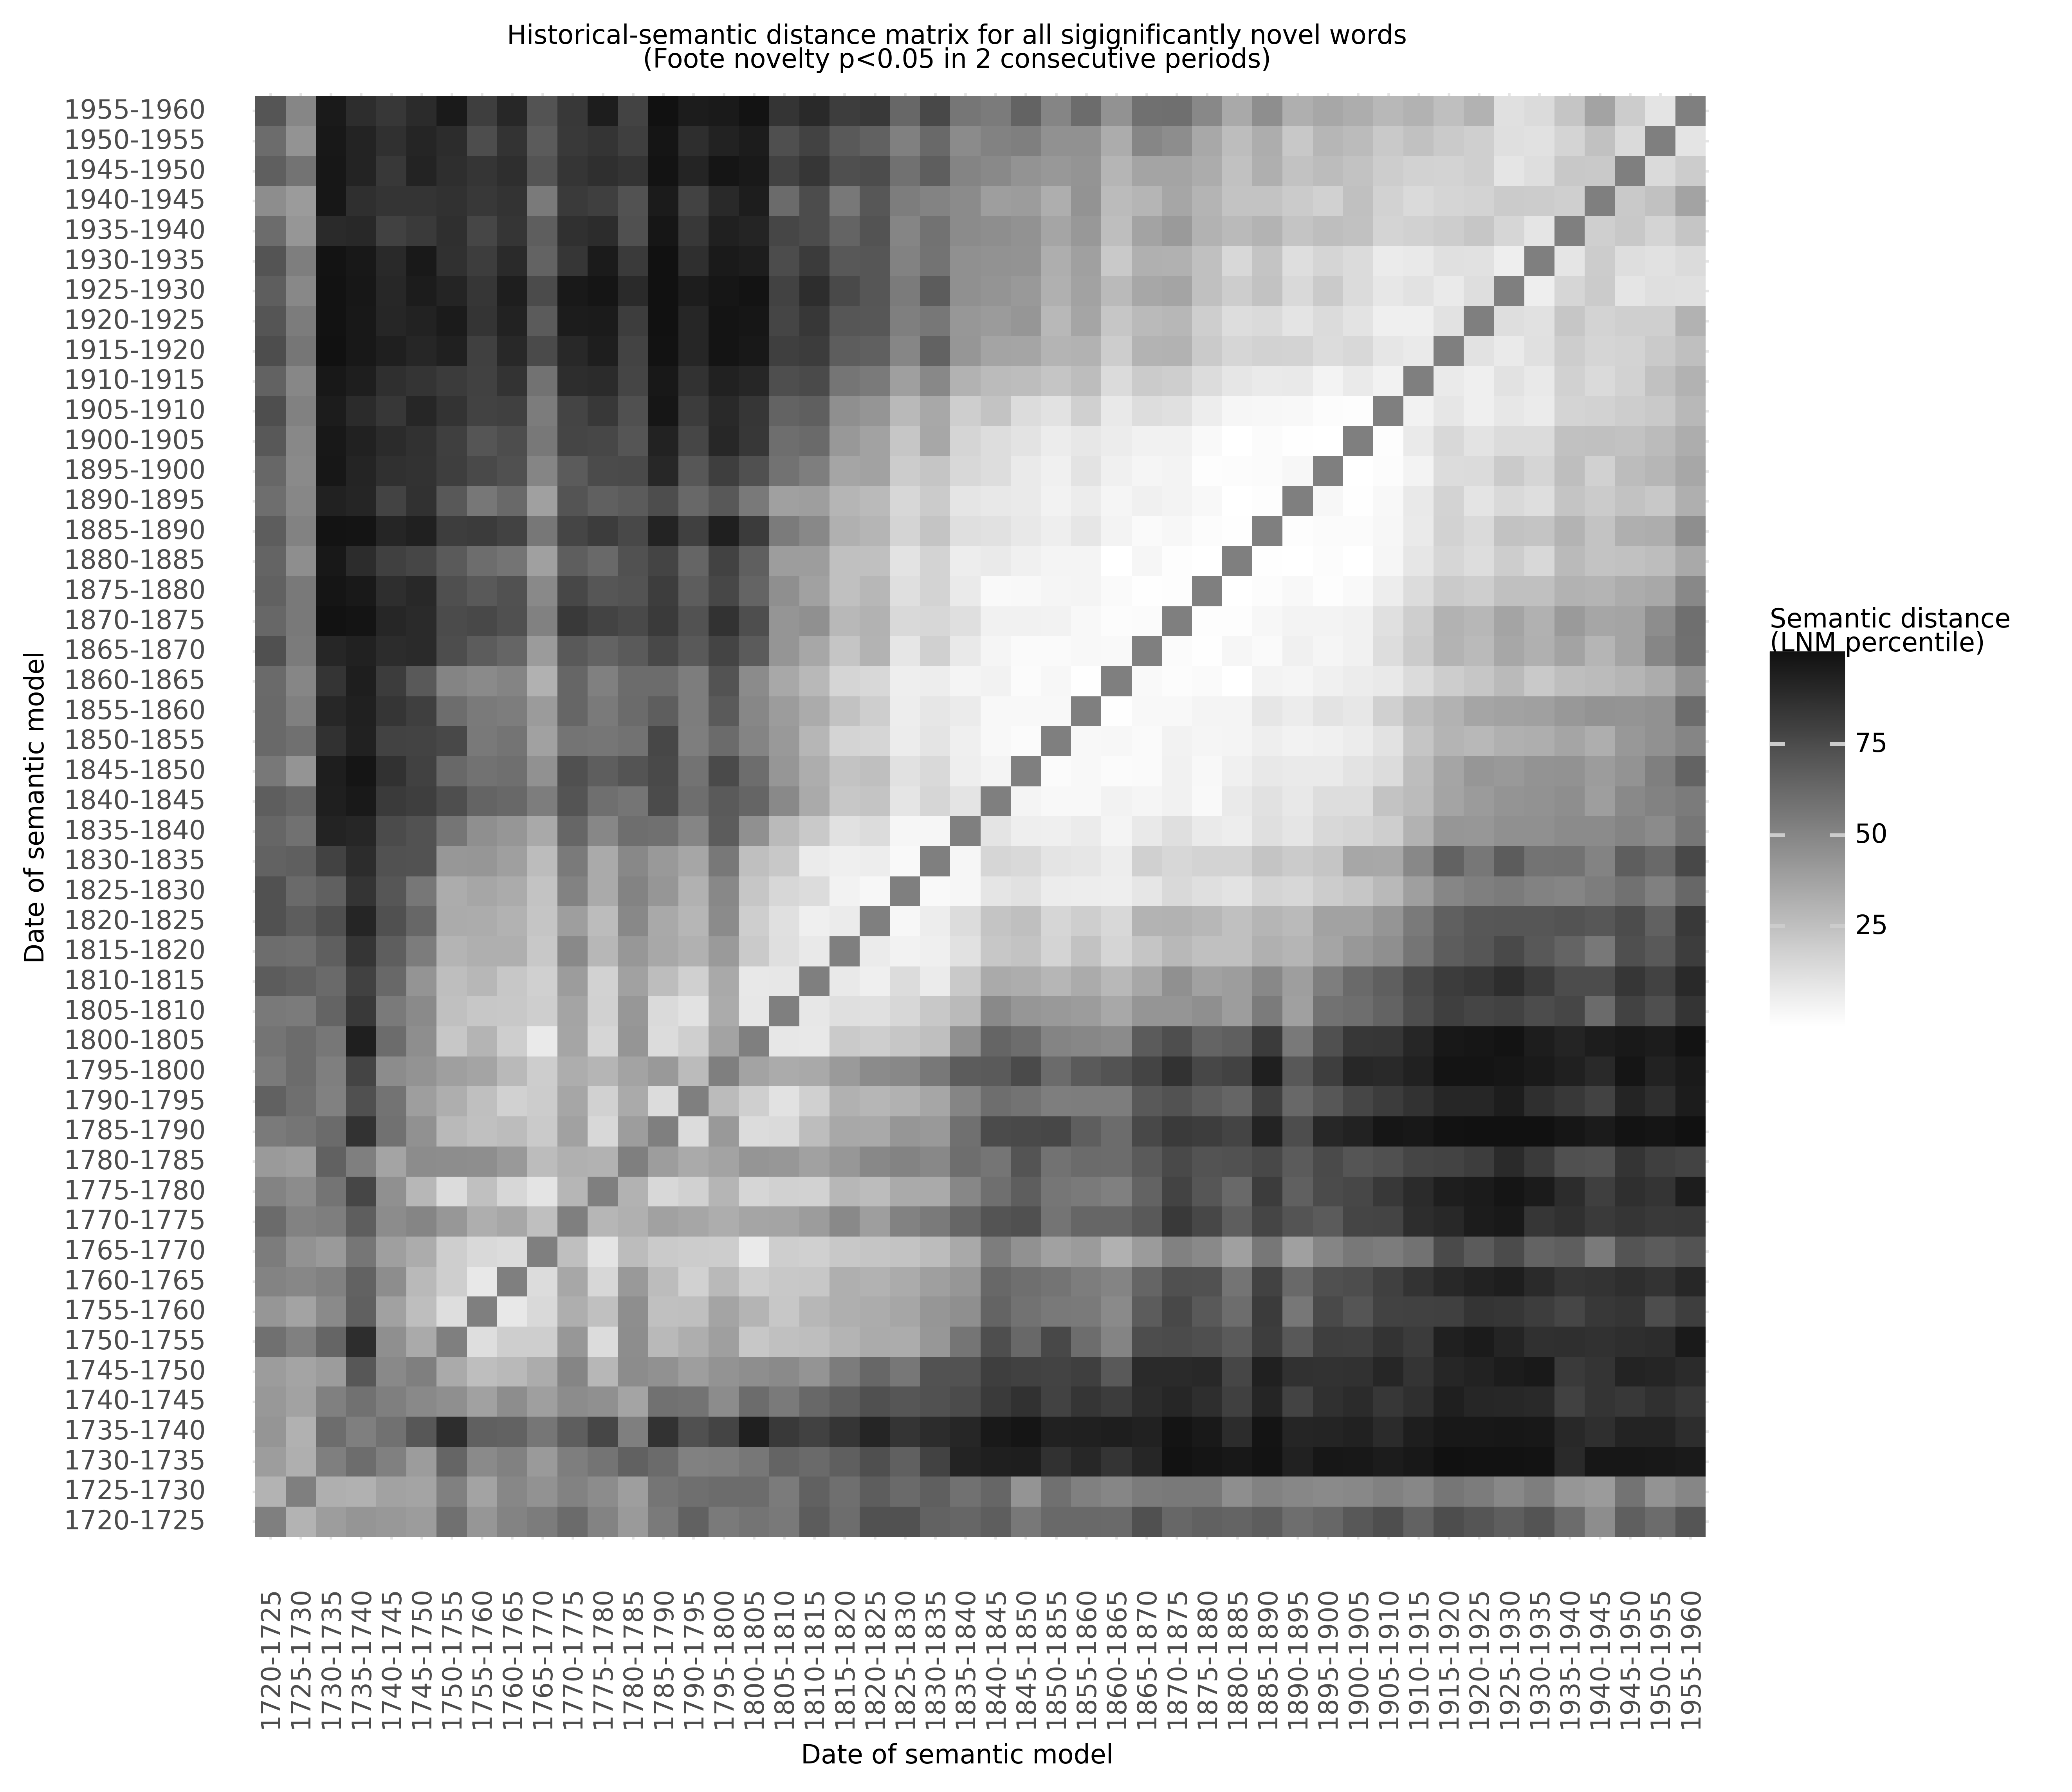

<ggplot: (8773260537326)>

In [45]:
plot_distmat(dfdist_allnovwords,
             title='Historical-semantic distance matrix for all sigignificantly novel words\n(Foote novelty p<0.05 in 2 consecutive periods)')

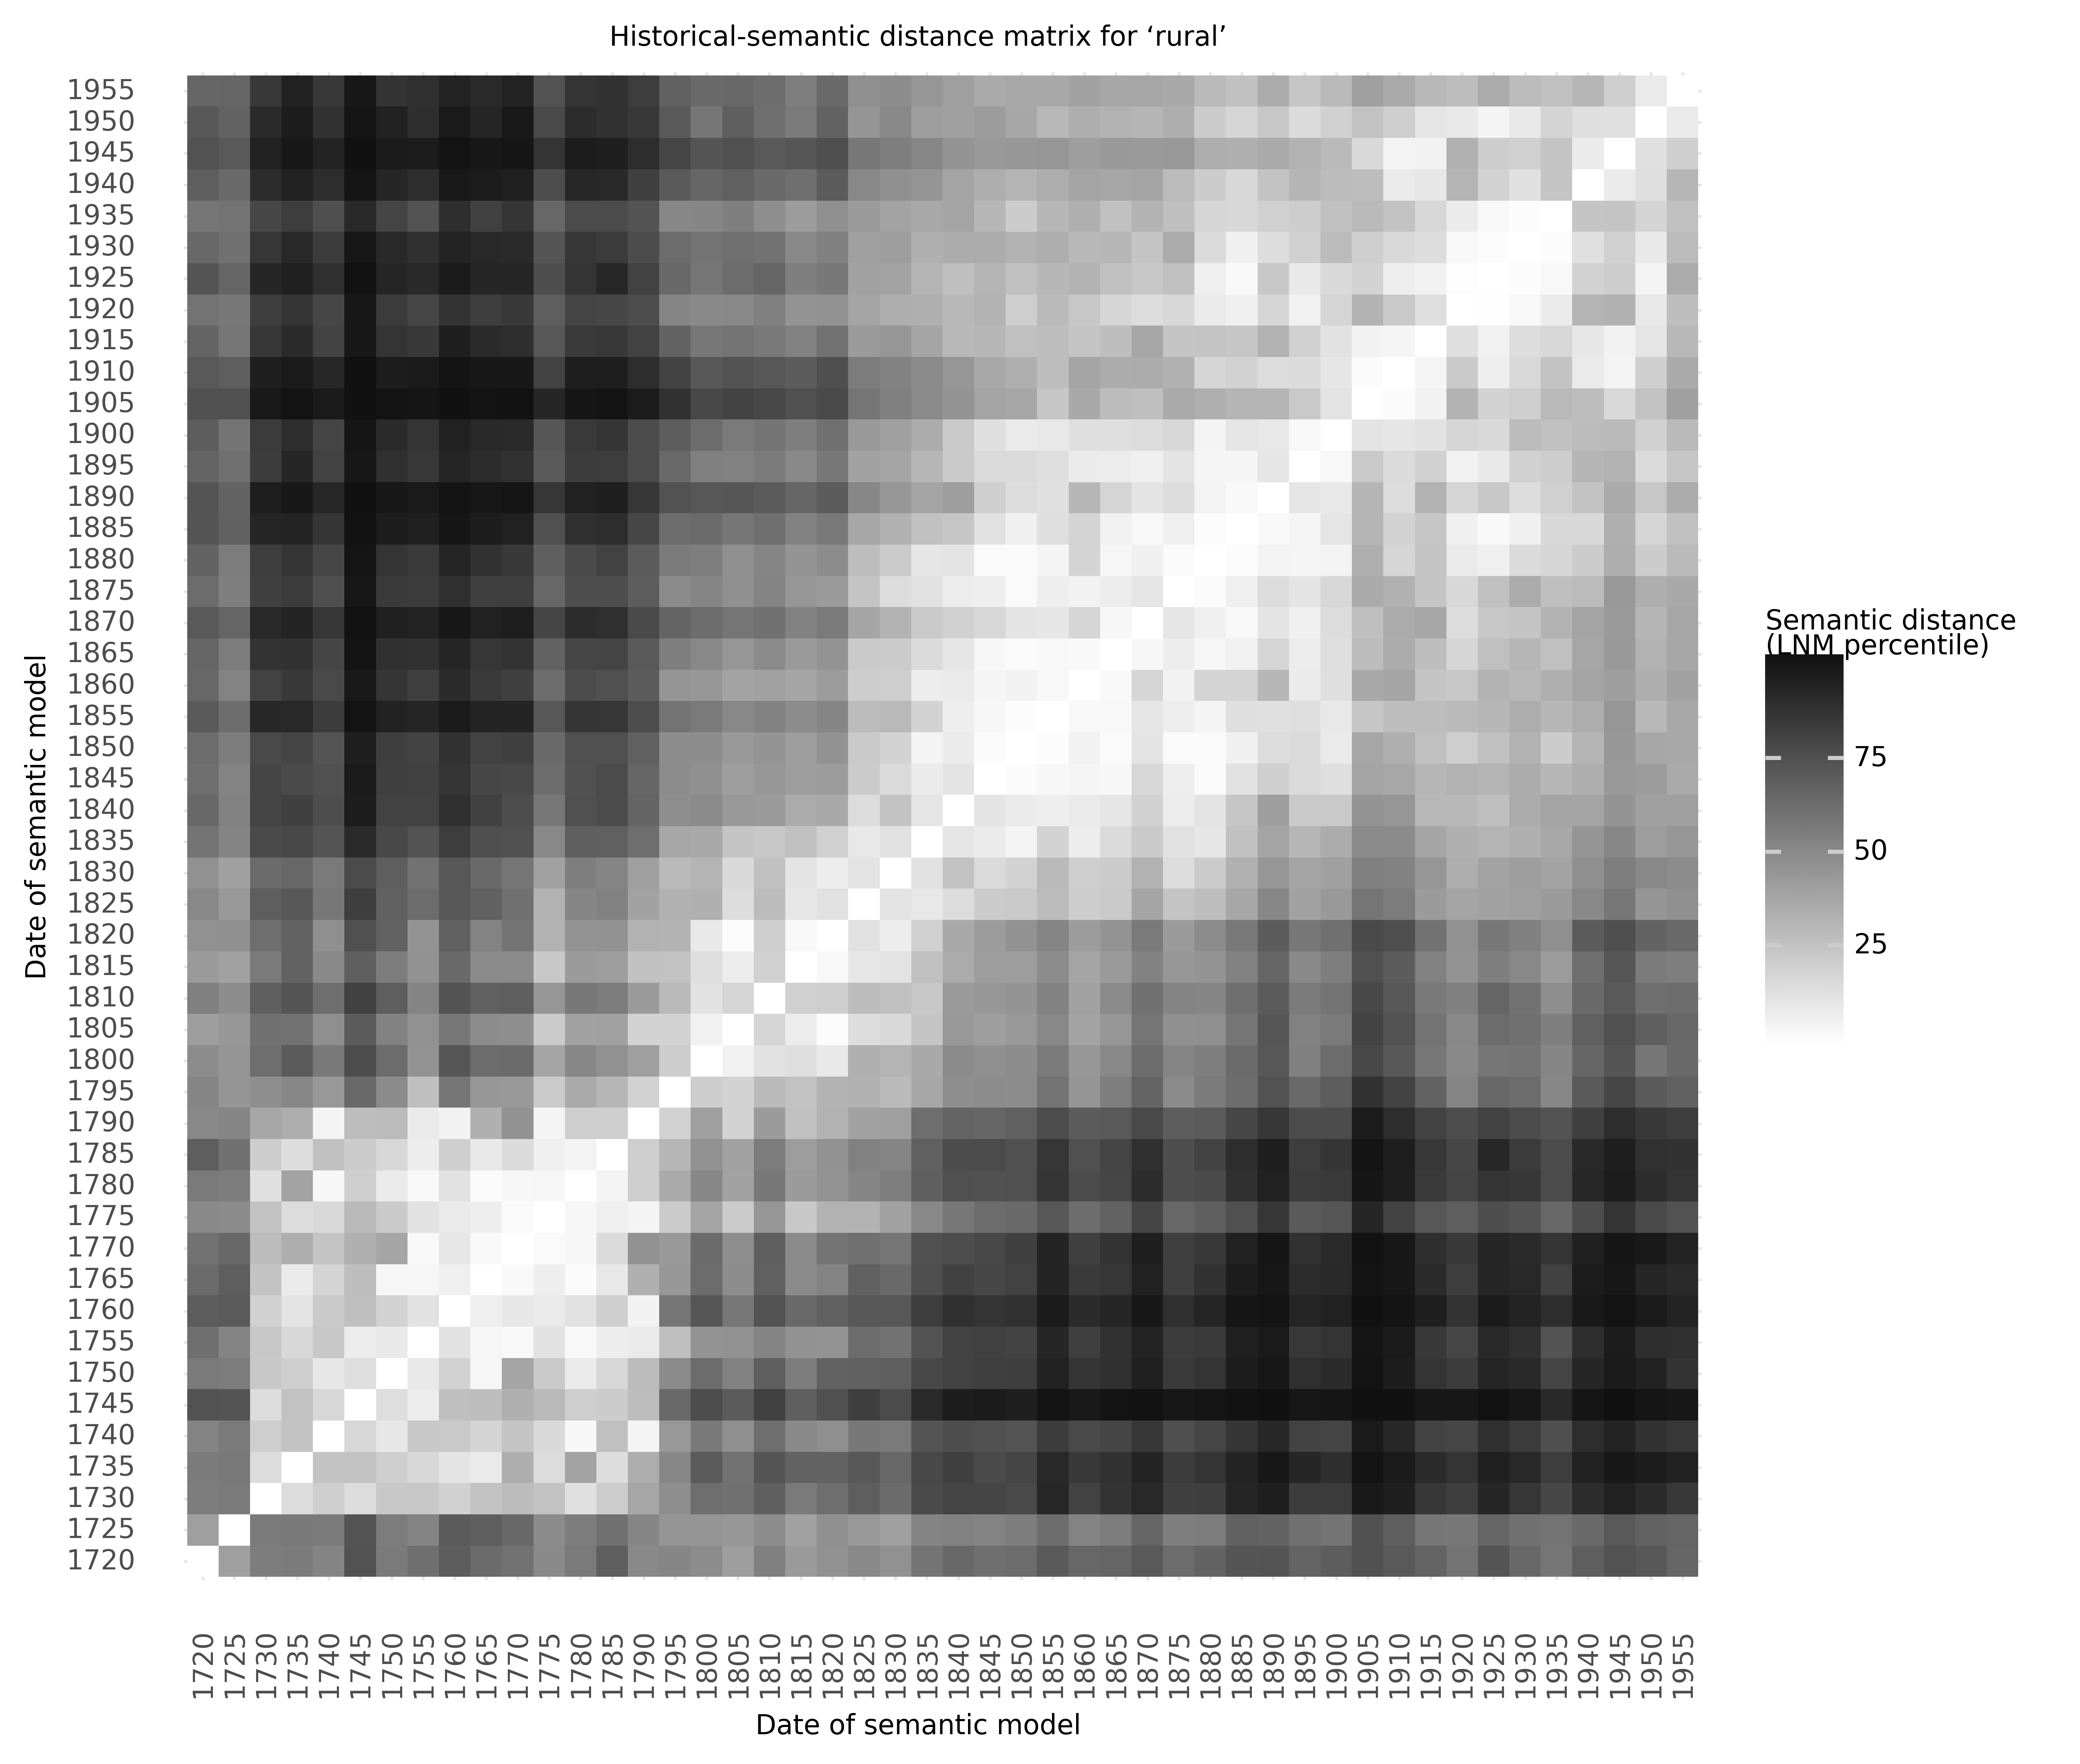

<ggplot: (8773238661078)>

In [59]:
plot_historical_semantic_distance_matrix('rural')

## Plot

In [42]:
def plot_distmat(distdf,xcol='period1',ycol='period2',value_name='lnm_perc',percentile=True,
                 use_color=False,xlim=None,ylim=None,title='Distance matrix',ofn=None,force=False,
                 invert=False,**y):
    if ofn:
        ofnfn=os.path.join(PATH_FIGS,ofn)
        if not force and os.path.exists(ofnfn): return ofnfn
    
    
    distdfm=distdf.reset_index().melt(id_vars=[xcol],value_name=value_name)#.dropna()
    if percentile:
        distdfm[value_name]=distdfm[value_name].rank() / len(distdfm[value_name]) * 100
    
    
    fig=start_fig(
        distdfm,
        x=f'factor({xcol})',
        y=f'factor({ycol})',
        fill=value_name,
        **y
    )
    fig+=p9.geom_tile()
    if not use_color:
        if not invert:
            fig+=p9.scale_fill_gradient(high='#111111',low='#FFFFFF')   
        else:
            fig+=p9.scale_fill_gradient(low='#111111',high='#FFFFFF')   
    else:
        fig+=p9.scale_fill_distiller(type='div',palette=5)
    fig+=p9.theme(
        axis_text_x=p9.element_text(angle=90)
    )
    fig+=p9.labs(
        x='Date of semantic model',
        y='Date of semantic model',
        fill='Semantic distance\n(LNM percentile)',
        title=title
    )
    if ofn:
        fig.save(ofnfn)
        if PATH_FIGS2: fig.save(os.path.join(PATH_FIGS2,ofn))
        return ofnfn
        
    return fig


def plot_historical_semantic_distance_matrix(words,save=False,force=False,force_data=False,dist_key='lnm',interpolate=False,vnum='v35',**y):
    wstr=words.strip() if type(words)==str else '-'.join(words)
    wstr2=words.strip() if type(words)==str else ', '.join(words)
    dfdist=distmat(
        words,
        dist_key=dist_key,
        interpolate=interpolate,
        force=force_data,
        **y
    )
    dfdist=dfdist.rename(lambda x: x[:4],axis=1)
    dfdist=dfdist.rename(lambda x: x[:4],axis=0)
    res=plot_distmat(
        dfdist.fillna(0),
        figure_size=(8,8),
        ofn=f'fig.{wstr}.distmat.{vnum}.png' if save else None,
        title=f'Historical-semantic distance matrix for ‘{wstr2}’',
        force=force
    )
    return print_img(res) if save else res



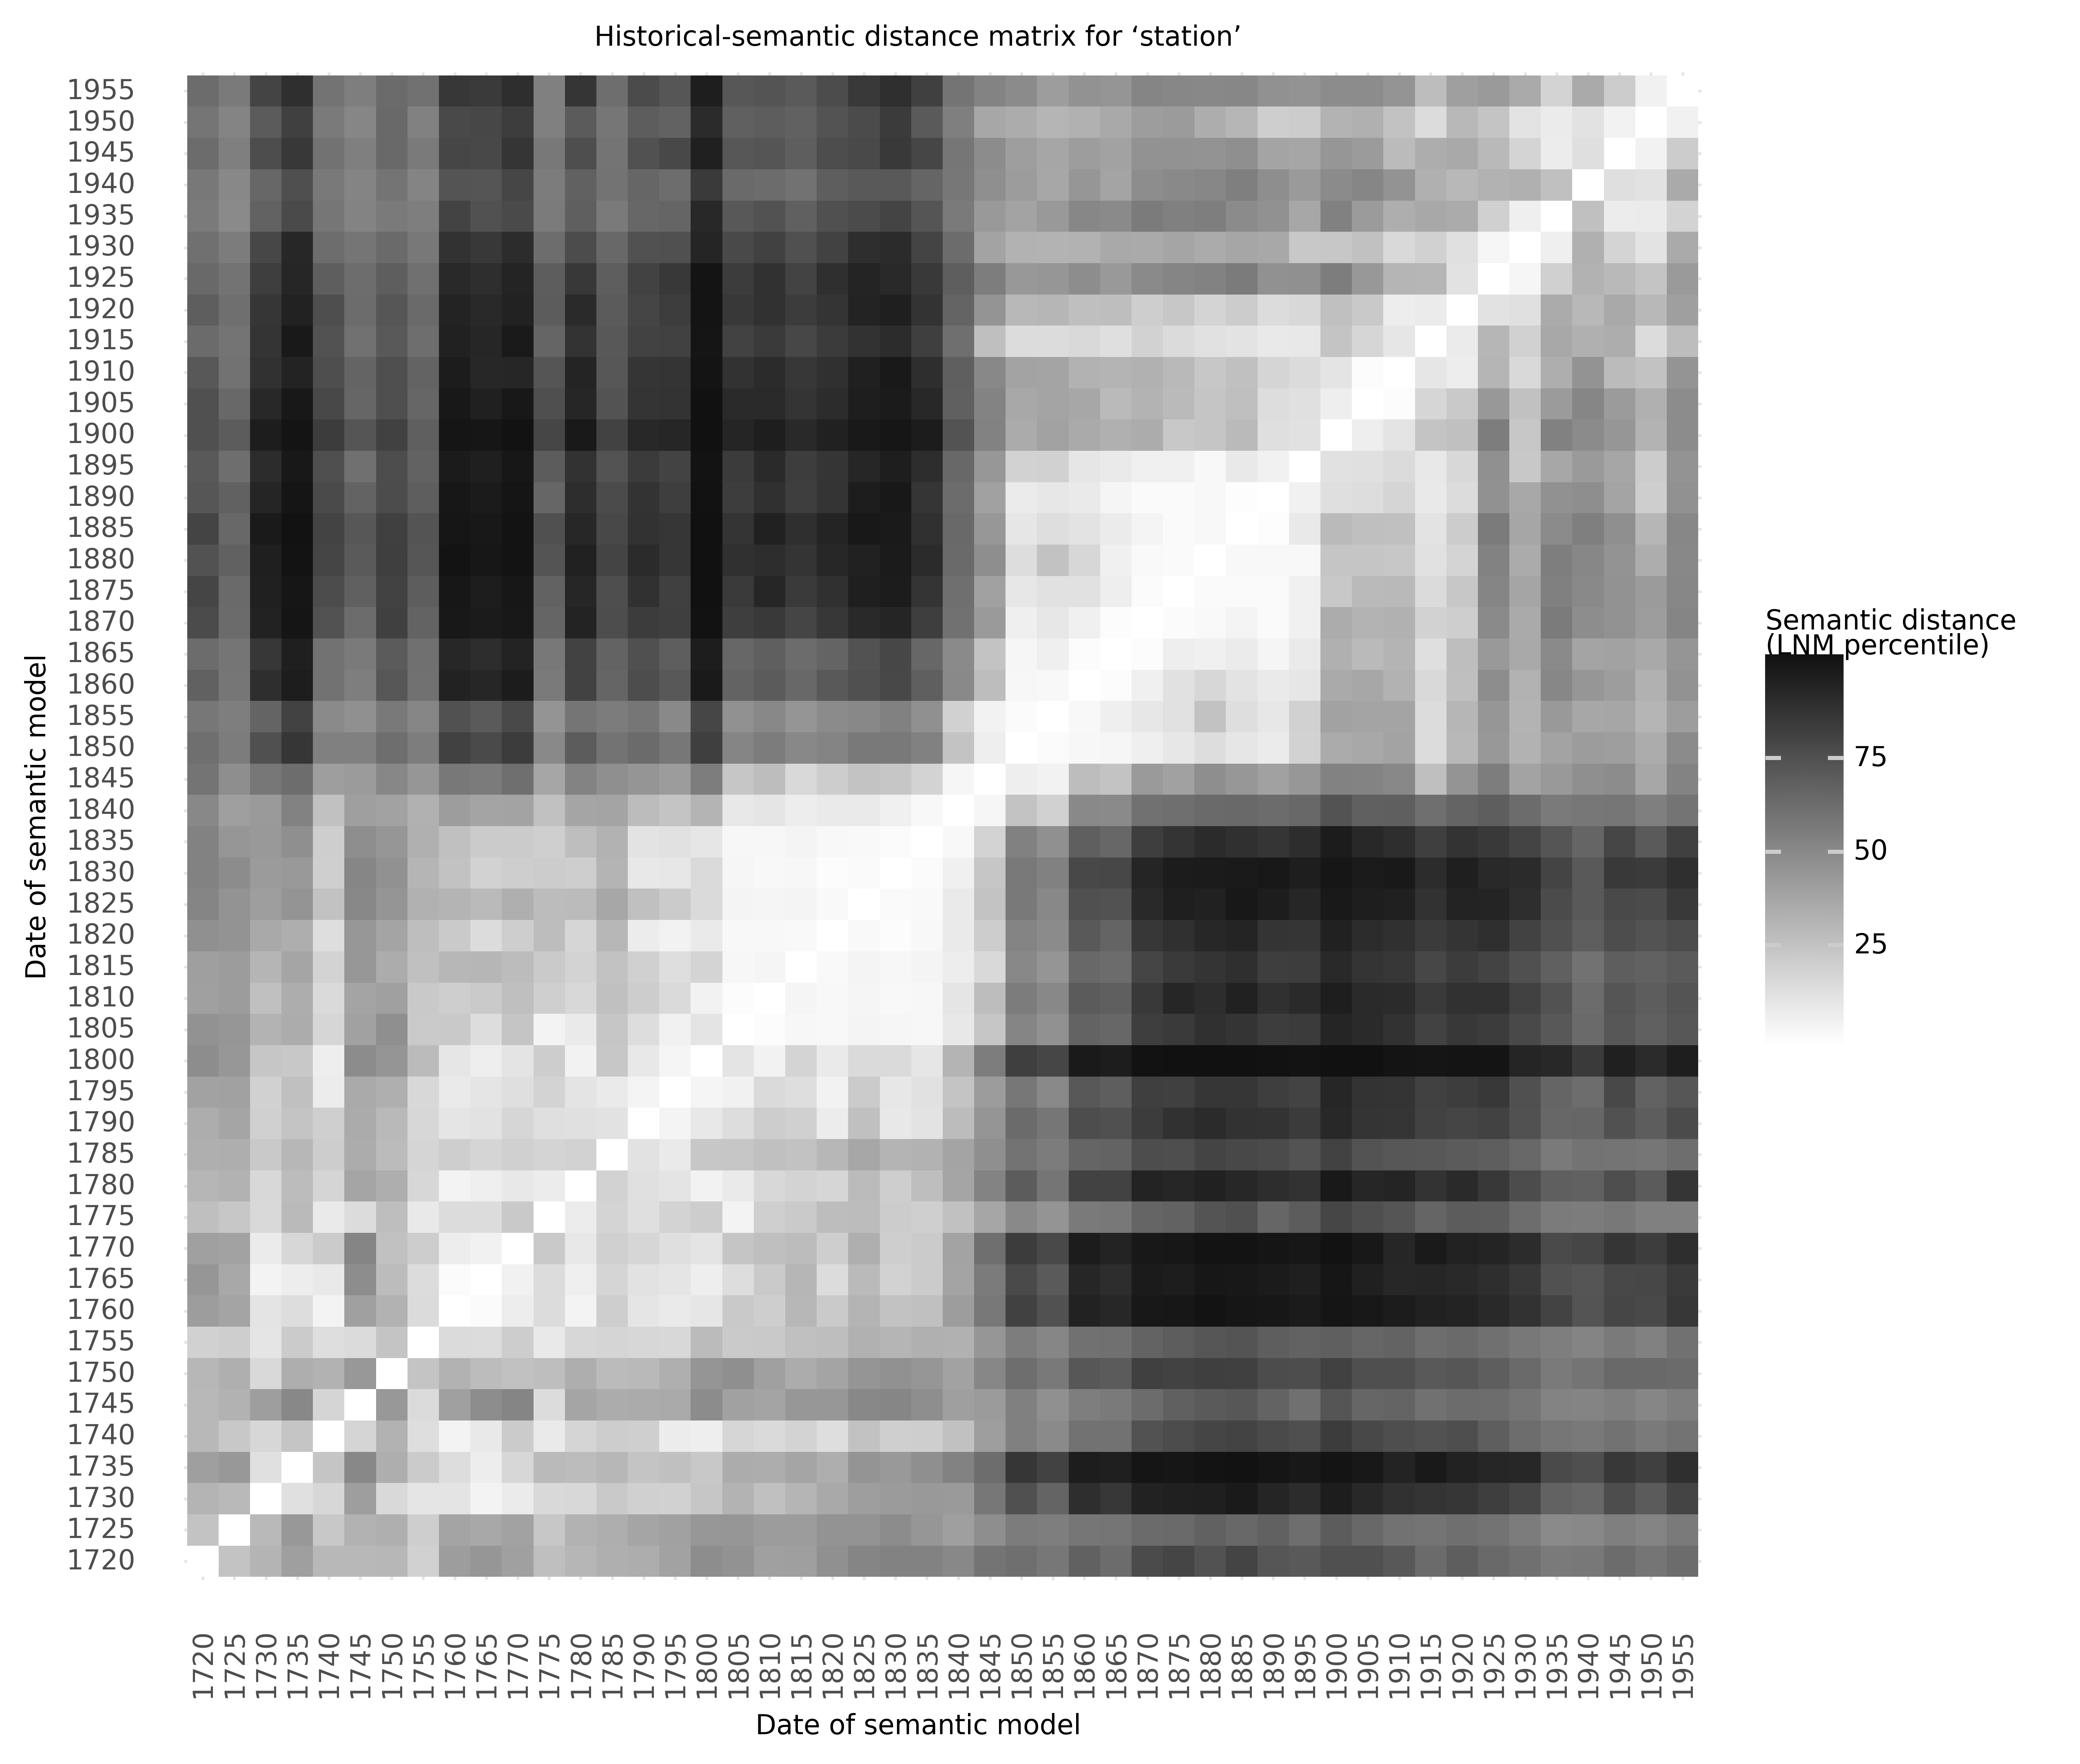

<ggplot: (8747114772797)>

In [45]:
plot_historical_semantic_distance_matrix('station')

In [9]:
# plot_historical_semantic_distance_matrix('culture',force=True,k=10,ymin=1700,ymax=1900,ybin=5,num_proc=4)

In [10]:
def gettodaysdate(): return time.strftime('%Y-%m-%d')

In [11]:
def iplot_historical_semantic_distance_matrix(w='culture', **attrs):
    attrs={**dict(
        words=w,
        force=True,
        dist_key=fixed('lnm'),
        k=10,
        ymin=1720,
        ymax=1900,
        ybin=5,
        force_data=False,
        vnum=gettodaysdate(),
        save=False,
        num_runs=3,
        num_proc=3),**attrs}
    res=interact_manual_plot(plot_historical_semantic_distance_matrix, **attrs)
    return res

In [12]:
# res=iplot_historical_semantic_distance_matrix('liberty')

## Correlating distance matrices

In [13]:
from skbio.stats.distance import mantel

In [14]:
# %%timeit
# x=distmat('culture').fillna(0)
# y=distmat('station').fillna(0)
# z=distmat('virtue').fillna(0)

In [15]:
# %%timeit
# corr_x2y = mantel(x, y, method='pearson', permutations=100, alternative='two-sided', strict=False, lookup=None)

In [16]:
# corr_x2z = mantel(x, z, method='pearson', permutations=999, alternative='two-sided', strict=False, lookup=None)
# corr_y2z = mantel(y, z, method='pearson', permutations=999, alternative='two-sided', strict=False, lookup=None)

In [17]:
# xs,ys,zs='culture','station','virtue'

# print(xs,ys,corr_x2y)
# print(xs,zs,corr_x2z)
# print(ys,zs,corr_y2z)

In [18]:
def corr_distmats(dist1,dist2):
    try:
        res = mantel(
            dist1.fillna(0),
            dist2.fillna(0),
            method='pearson',
            permutations=100,
            strict=False
        )
        odx={}
        odx['corr'],odx['p_value'],odx['n'] = res
        return odx
    except ValueError as e:
        return {}

In [19]:
# corr_distmats(
#     distmat('culture'),
#     distmat('slave')
# )

In [20]:
# distmat('culture')

In [21]:
def do_corr_distmat_words(obj):
    distmat1,word1,word2 = obj
    odx={'word1':word1, 'word2':word2}
    try:
        odx={**odx, **corr_distmats(distmat1,distmat(word2).fillna(0))}
    except Exception as e:
        pass
    return odx

def corr_distmat_words(word,words=None,num_proc=1,
                       ymin=YMIN_DISTMAT, ymax=YMAX_DISTMAT, ybin=YBIN_DISTMAT, k=K,
                       force=False,progress=True,
                       **distmat_opts):
    words_todo=words=[w for w in (get_keywords() if words is None else words) if w!=word]
    def to_qstr(w):
        w1,w2=sorted([word,w])
        return f'distmat/{w1}/{w2}/{ymin}-{ymax}_{ybin}/k={k}'
    
    
#     print('# objs',len(words_todo))
    if not force:
        with get_db('corrs') as db:
            words_todo=[w for w in words if to_qstr(w) not in db]
#     print('# todo',len(words_todo))
    
    if len(words_todo):
        try:
            distmat1=distmat(word,progress=False).fillna(0)
        except Exception as e:
#             print('!!',word,e)
            return pd.DataFrame()
        
        objs=[(distmat1,word,w) for w in words_todo]
        iterr=pmap_iter(do_corr_distmat_words, objs, num_proc=num_proc, progress=progress)
        l=[]
        with get_db('corrs','c') as db:
            for w,res in zip(words_todo,iterr):
#                 print(w,res)
                db[to_qstr(w)]=res
            db.commit()
        #corr_df = pd.DataFrame(iterr)
    
    with get_db('corrs','r') as db:
        corr_df=pd.DataFrame(db[to_qstr(x)] for x in words if to_qstr(x) in db)
    #if len(corr_df):
    #    corr_df=corr_df.dropna().sort_values('corr',ascending=False)
    return corr_df

In [22]:
# corr_distmat_words('polish',['vice','honesty','door','virtue'],force=False)

In [23]:
# cordf_slv=corr_distmat_words('slave',words=get_keywords(),num_proc=2)
# cordf_slv

In [24]:
# cordf_sta=corr_distmat_words('station',num_proc=4)
# cordf_sta

In [25]:
# cordf_dem=corr_distmat_words('demand',num_proc=4)
# cordf_dem

In [26]:
def corr_distmat_pairwise(words=None,progress=True,**opts):
    if not words: words=get_keywords()
    words=list(words)
    random.shuffle(words)
    l=[]
    for w1 in tqdm(words,position=0,desc='Computing pairwise comparisons',disable=not progress):
        w2l = [w2 for w2 in words if w1<w2]
        df = corr_distmat_words(w1,w2l,progress=False,**opts)
        l+=[df]
    return pd.concat(l) if len(l) else pd.DataFrame()

In [130]:
w2pos=lltk.get_word2pos()
wl = [w for w in get_signif_novelty_words() if w2pos.get(w)=='nn1']
#len(wl),'culture' in set(wl)

In [131]:
#wl=random.sample(list(get_signif_novelty_words()),10)
# wl=get_keywords()
# df=corr_distmat_pairwise(wl,num_proc=4)

In [132]:
# stop

In [133]:
df=df.dropna().sort_values('corr',ascending=False)
df['corr_rank']=df['corr'].rank(ascending=False)
df['corr_perc']=df['corr'].rank(ascending=True) / len(df) * 100
df2=df.assign(word1=df.word2, word2=df.word1)
dfboth=df.append(df2)
dfpiv=dfboth.pivot('word1','word2','corr')

In [65]:

def draw_bokeh(G,
    title='Networkx Graph', 
    save_to=None,
    color_by=None,
    size_by=None,
    default_color='skyblue',
    default_size=15,
    min_size=5,
    max_size=30,
    show_labels=True,
    notebook=True,
):
    import networkx as nx
    from bokeh.io import output_notebook, show, save
    from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
    from bokeh.plotting import figure
    from bokeh.plotting import from_networkx
    from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
    from bokeh.transform import linear_cmap
    from networkx.algorithms import community
    from bokeh.plotting import from_networkx
    if notebook: output_notebook()
    
    #Establish which categories will appear when hovering over each node
    HOVER_TOOLTIPS = [("ID", "@index")]#, ("Relations")]

    #Create a plot — set dimensions, toolbar, and title
    # possible tools are pan, xpan, ypan, xwheel_pan, ywheel_pan, wheel_zoom, xwheel_zoom, ywheel_zoom, zoom_in, xzoom_in, yzoom_in, zoom_out, xzoom_out, yzoom_out, click, tap, crosshair, box_select, xbox_select, ybox_select, poly_select, lasso_select, box_zoom, xbox_zoom, ybox_zoom, save, undo, redo, reset, help, box_edit, line_edit, point_draw, poly_draw, poly_edit or hover
    plot = figure(
        tooltips = HOVER_TOOLTIPS,
        tools="pan,wheel_zoom,save,reset,point_draw",
            active_scroll='wheel_zoom',
#             tools="",
        x_range=Range1d(-10.1, 10.1),
        y_range=Range1d(-10.1, 10.1),
        title=title
    )

    #Create a network graph object with spring layout
    # https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html

    #Set node size and color

    # size?
    size_opt = default_size
    if size_by is not None:
        size_opt = '_size'
        data_l = X = np.array([d.get(size_by,0) for n,d in G.nodes(data=True)])
        data_l_norm = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        data_scaled = [(min_size + (max_size * x)) for x in data_l_norm]
        for x,n in zip(data_scaled, G.nodes()):
            G.nodes[n]['_size']=x


    # get network
    network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))



    # render nodes
    network_graph.node_renderer.glyph = Circle(
        size=size_opt, 
        fill_color=color_by if color_by is not None else default_color
    )

    #Set edge opacity and width
    network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

    #Add network graph to the plot
    plot.renderers.append(network_graph)

    #Add Labels
    if show_labels:
        x, y = zip(*network_graph.layout_provider.graph_layout.values())
        node_labels = list(G.nodes())
        source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
        labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
        plot.renderers.append(labels)

    show(plot)
    if save_to: save(plot, filename=save_to)

In [134]:
def plot_distmat_nx(df):
    fig = go.Figure(data=go.Heatmap(z=df, x=df.index, y=df.columns, colorscale='gray',reversescale=True))
    fig.update_layout(width=800,height=800)
    return fig

In [142]:
# fig = ff.create_dendrogram(dfpiv.fillna(0), orientation='left', labels=dfpiv.index)
# fig.update_layout(width=800, height=1600)
# fig.show()

In [158]:
gdf = dfboth[dfboth.p_value<=0.05].sort_values('corr_rank').groupby('word1').head(1).sort_values('word1')
signw=set(get_signif_novelty_words())
def decide_if_sign(w): return f'{w}*' if w in signw else w
gdf['word1']=gdf.word1.apply(decide_if_sign)
gdf['word2']=gdf.word2.apply(decide_if_sign)
gdf

,word1,word2,corr,p_value,n,corr_rank,corr_perc
38,administration,constitution,0.837786,0.009901,36.0,23.0,99.630003
55,anarchy,mechanical,0.770644,0.009901,36.0,313.0,94.752775
92,aristocracy,creative,0.718545,0.009901,33.0,994.0,83.299697
14,authority,private,0.777652,0.009901,36.0,266.0,95.543222
117,balance,criticism,0.808694,0.009901,36.0,90.0,98.503195
...,...,...,...,...,...,...,...
143,violence,experience,0.756198,0.009901,36.0,452.0,92.415069
18,war,reputation,0.705535,0.009901,36.0,1215.0,79.582913
100,wealth,intellectual,0.788804,0.009901,36.0,188.0,96.855029
107,welfare,individual,0.790931,0.009901,36.0,172.0,97.124117


In [161]:
# gdf[gdf.word2.str.endswith('*')]

In [162]:
g=nx.from_pandas_edgelist(
    gdf,
    source='word1',
    target='word2',
    edge_attr=['corr','p_value','n','corr_rank','corr_perc']
)


In [163]:
draw_bokeh(g)

Loading BokehJS ...

In [147]:
gdf[gdf.word1=='culture']

,word1,word2,corr,p_value,n,corr_rank,corr_perc
155,culture,liberal,0.781376,0.009901,36.0,234.0,96.081399
